# Imports

In [1]:
import sys
from preprocessed_mnist import load_dataset
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

sys.path.append("..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import keras_utils
from keras_utils import reset_tf_session

from sklearn.metrics import accuracy_score

C:\Users\shekaul\AppData\Local\Continuum\anaconda3\envs\coursera\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Loading data and plot some examples

X_train shape : (50000, 28, 28)
y_train 5 firsts : [5 0 4 1 9]


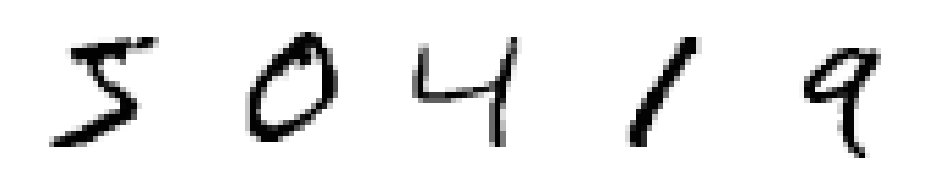

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print("X_train shape :", X_train.shape);
print("y_train 5 firsts :", y_train[:5]);
%matplotlib inline
fig=plt.figure(figsize=(16, 16))
for i in range(0, 5):
    fig.add_subplot(1, 5, i+1)
    plt.imshow(X_train[i], cmap="Greys");
    plt.axis('off')
plt.show()

# Some reshaping of the input features and labels
Instead of using a 3D matrix (example,value_X,value_Y) for the input features *X_train, X_val, X_test*, we can use a 2D matrix (example,value). For that we will reshape using np.reshape(..) function

In [3]:
nb_pix = X_train.shape[1]**2
X_train = X_train.reshape((X_train.shape[0],nb_pix))
X_val   = X_val.reshape((X_val.shape[0],nb_pix))
X_test  = X_test.reshape((X_test.shape[0],nb_pix))

We also need to convert our labels *y_train, y_val* from a vector of natural numbers ranging from 0 to 9 to a binary 2D matrix (#examples,10) where each rows are the onehot encoded vector representation of the natural number

In [4]:
zeros = np.zeros([y_train.shape[0],10])
zeros[range(0,y_train.shape[0]),y_train]=1.0
y_train_vect = zeros

zeros = np.zeros([y_val.shape[0],10])
zeros[range(0,y_val.shape[0]),y_val]=1.0
y_val_vect = zeros

zeros = np.zeros([y_test.shape[0],10])
zeros[range(0,y_test.shape[0]),y_test]=1.0
y_test_vect = zeros

## Instanciate variables and placeholders and define computation graphs
* For the layers activations: placeholders and inputs
* For the model parameters: variables

weights are initially randomly set to break symmetry during learning process

In [5]:
n_hidden1 = 250 # number of units in the hidden layer 1
n_hidden2 = 100 # number of units in the hidden layer 2
tf.set_random_seed(42) # let's have the same behavior for all the runs


s = reset_tf_session()

# inputs
input_X = tf.placeholder('float32', shape=(None, nb_pix), name="X")
input_y = tf.placeholder('float32', shape=(None, 10),     name="y")
# Parameters
winit = tf.contrib.layers.xavier_initializer()
weights_l1 = tf.get_variable("w_hidden1",shape=(nb_pix,n_hidden1),    dtype=tf.float32, initializer=winit)
weights_l2 = tf.get_variable("w_hidden2",shape=(n_hidden1,n_hidden2), dtype=tf.float32, initializer=winit)
weights_l3 = tf.get_variable("w_hidden3",shape=(n_hidden2,10),        dtype=tf.float32, initializer=winit)
b_l1 = tf.get_variable("b_l1",shape=(n_hidden1), dtype=tf.float32, initializer=tf.zeros_initializer())
b_l2 = tf.get_variable("b_l2",shape=(n_hidden2), dtype=tf.float32, initializer=tf.zeros_initializer())
b_l3 = tf.get_variable("b_l3",shape=(10)       , dtype=tf.float32, initializer=tf.zeros_initializer())

## Forward pass

$$
h_1 = X.W_{1} + b_1
$$
$q_1$ is the element-wise sigmoid application on $h_1$:
$$
q_1 = sigmoid(h_1)
$$
Each element (j,i) in matrix $q_1$ is the activation of the neuron (i) for example (j).

        .. same for other hidden layers ..

Each element (j,i) in matrix $q_3$ is classifier result for class (i) and for example (j) and must be interpreted as the probability of example (j) to represent the digit (i)
$$
P_j(y=i | h_3(j,i)) = softmax(h_3(j,i)) = \frac{e^{h_3(j,i)}}{\Sigma e^{h_3(j,[0:9])}}
$$

The sum over $q_3(j,[0:9])$ is equal to 1.

In [6]:
h_1 = tf.add( tf.matmul(input_X, weights_l1), b_l1 )
q_1 = tf.nn.relu(h_1)

h_2 = tf.add( tf.matmul(q_1, weights_l2), b_l2)
q_2 = tf.nn.relu(h_2)

h_3 = tf.add( tf.matmul(q_2, weights_l3), b_l3 )
q_3 = tf.nn.softmax(h_3)

## Loss function
I use the cross entropy loss function

In [7]:
## 2 HIDDEN
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = input_y, logits = h_3)) 
## 1 HIDDEN
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = input_y, logits = h_2)) 

#Manually compute cross entropy
#losses = -(input_y*tf.log(q_2) + (1-input_y)*tf.log(1-q_2))
#loss_sum = tf.reduce_sum(losses, 1)
#loss     = tf.reduce_mean(loss_sum, name="loss_mean") # average over the examples

## Predictions

In [8]:
## 2 HIDDEN
predicted_classes = tf.argmax(q_3,1)
## 1 HIDDEN
# predicted_classes = tf.argmax(q_2,1)

## Optimize weights and biases

In [9]:
step = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08) \
                  .minimize(loss, var_list=[weights_l1,weights_l2,weights_l3,b_l1,b_l2,b_l3])
    
# step = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08) \
#                    .minimize(loss, var_list=[weights_l1,weights_l2,b_l1,b_l2])

# Learning

For some reason, the computed loss after a certain number of epochs turn out to be NaN..

In [10]:
%%time
s.run(tf.global_variables_initializer())

BATCH_SIZE = 256
STAGNATION_LIMIT = 10
IMPROVE_LIMIT = 0.1
# if the accuracy did not improve by {IMPROVE_LIMIT}% {STAGNATION_LIMIT} times in a row : training stops

train_losses, val_losses = [],[]
epoch      = 0
stagnation = 0
last_acc   = float('inf')

#live plot
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

while stagnation<STAGNATION_LIMIT:  # we finish an epoch when we've looked at all training samples
    batch_losses = []
    for batch_start in range(0, X_train.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_vect[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    # compute loss and predictions for validation (validation set is small)
    val_loss,predictions = s.run([loss, predicted_classes], {input_X: X_val, input_y: y_val_vect}) 
    # save values for further plotting
    val_losses.append(val_loss)
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)
    
    ## Debug prints
    #print("--")
    #print("epoch: %d   train_loss : %f val_loss : %f"%(epoch,train_loss,val_loss))
    #print("Validation accuracy : %f prct"%(validation_accuracy))
    #print("--")
    ## Debug prints
    
    # compute the accuracy on validation set
    miss_classified = np.count_nonzero(abs(y_val - predictions))
    validation_accuracy = 100*(X_val.shape[0] - miss_classified) / X_val.shape[0]
    # Early stopping
    if abs(last_acc-validation_accuracy) < IMPROVE_LIMIT:
        stagnation += 1
    else:
        stagnation = 0
    last_acc = validation_accuracy
    
    ## debug plots
    train_accuracy = accuracy_score(y_train, s.run(predicted_classes, {input_X: X_train}))
    valid_accuracy = accuracy_score(y_val, s.run(predicted_classes, {input_X: X_val}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)
    ##
    
    epoch      = epoch + 1

print("Training done after %d epochs.. (accuracy on the validation set : %f)"%(epoch,last_acc))

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvPfjt%2B1J8FP2b5NGsfil4g1Maj4ilnTQNB8OeF9R1zVNR8lVed4bHTbee5kjiVkMkixlI96biu5c%2BhV4N%2B0P8D/j5/wANJ%2BDv2tv2bLLwfrWueH/B2seFNX8KeOdcutLtLywv7mwuxcQXtraXj288U2noCpt3WVJSCUKK1ABpf/BTL9izWLvxPb2nxXv0h8FWsk/jLUrvwXrEFjoIS0iu9l5dy2iwWsrQzRskMjrJIWKorMrKL2n/APBQ/wDZK1HwBrXxFTx/q9vB4f1ay0vVdE1DwNrNrrkV5ebfscC6PNaLqEr3AYGER27eaAxTcFYjy2b9gH4y%2BMf2a/jn8NfGHinwppHin4o/FS38daHc6U1xeWFpeW0OiywQ3IkihkkiN3pRRwoyYHGDuJVaPi79i/8AaV%2BLmr/Ef45fG34S/CjWvFnjWx8KaPp/gKy%2BI2s2Wm6fY6Hcaldw3qa7b6al5DqDXOqTOksVoPJSKNFZiWcgHsviH9vv9mzwv4a8OeI9XvvG3meK0v5NE8P2vwm8SXGuSRWUscV3NJpMWntf28MLzQq8s0CIpmiy37xM%2Bmaz8RPBHhv4e3XxX8T%2BJbbSvDljo76rf6vqrfZYbSySIzPPMZdvlKsYLNvxtAOcYNfGHin9hH9s/WPgX4X8Nay3hfxV470a58RHRfGV/wDHbxNpGr%2BCLW%2BuUktLO11q1sJLzXIYkjhEy3qw/aTbReYCFGPUfjR/wTotfj1%2Bzb4n%2BHHxD%2BOfjW78d%2BMPhfH4Z17xS3jbWho818tpDE2oJoS3y2FuzzQLK3kRRSEPIBIrSM5AOkg/4KUfsZf8K58V/FbWPite6Jo3giysr7xQ/ifwdq%2Bk3NlZXkxhtb37LeWsVxJaSyK6pcxxtC3luQ%2BEYjj/AI3f8FZP2d/hn8ENU%2BMfgPRfFXiqbQfiD4X8L674Y/4QXXbHU7A6zqVrax3T2cmnNdeV5Fw88DeT5d48aW8MhknjB8r1T/gmJ8ZPHfwq8faR4i8DeG9G8Y%2BI9D0fR7DxDqv7RfjPxut3aWusW%2BoTRyf27AfsEZ8likUSzHe%2BGkxknv8A9qH9gz40/GD4g/F/4g%2BBfEPheOTxfB8LbzwlZ6tfXMSvf%2BE/EdzrUsN40dvJ5ENwGt4VljEzrl2MfyKrgHqFh/wUE/Zb1H4m2XwZh8T%2BJo/Fd5oun6xLoF38N9egudO0%2B9adILu/SSyU6dDut5VeS68pYiFEhQum6j4a/wCCmH7FPi3wZ4s%2BIWkfGC4TR/Bfgi68Zaxe6h4S1W0Fx4et0Z5tWsVntUbVLNVQ4nsxPGxZArEugbB0P9kP4ofEP4mfG74g/G9fD2gxfGj4O%2BHfCF1Y%2BE9duNRl0u4tE11Ltlnns7XzYwNViMT7FZikm6OPA3fN37Y37Kn7UOj/ALDHxS%2BJv7TF34AtIfhD%2BxT8QfBHhePwFqF5cNrzXukWxn1G6W5toBYqE0i3CWcbXAVppCZ22oKAPrPw9/wUl/Yy8TaHrHiPT/i1dQWehppU1/JqnhLVbJmtNSu1s7HUIUuLVGubCWdgovoQ9qoDO0qorMPT9E%2BLvw88R/FLX/gvofiH7T4k8LaXp%2Boa/YR2k22zgvmuBa7pinlF3%2ByzHy1cyKoRmVVkjLfJOofsz%2BIPFegeKfjb/wAFIvF/wz8J%2BBbf9nu5%2BHUlx4f8QTLay6beyQyXmq3k17BbpYOTBbCG2QzCAmT/AEiQsuOw/wCCPngP4u2f7I9r8f8A9pDUDf8AxJ%2BL15H4n8V6g9nJbtJCLSCy01fKl%2BeH/iX2lpI0TYKSzTZAYtkA%2BqqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8R0j/AIKMfse6ld69Z6n8Urzw83hzw5c%2BINQk8a%2BEdV0GObSbd0jnv7WTUrWBb63R5IlaW2MqAyxjOXXPtN7FczWcsNndCCZ4mWKYx7/LYjhtp64POO9fmJq//BHL9uX4v6t4X1z43fHHQ31vw14P1Cz1DxRqHxW8TeJx4h1v7ZpV9a6idLvoobLSbaS50xfPsLIBRHJtWWQKgUA%2B2X/b/wD2YbX4aN8WNY8QeKtK0ttcg0axs9c%2BGWv2GqanfzIZIYLLTbixS9v2kQM6/Z4ZAyo7AkIxHReA/wBqz4H/ABH1%2By8J%2BHPEOqQ6vf8AhSfxJDpGteFdS0y7TTYbv7JLLLDeW8UkDrP8hhkVZe%2BzbzXk3xO%2BDn7bvxib4e/G3XPBvwq0P4h/Cjx1NrHh/wAM2vjjUr/Rdcs7jSbvTLmO4vn0qGaxmKXskkbpa3AjMQU%2BYJGxV%2BJPwG/bg1/4y%2BHf2mvA%2BjfCu08WX3ww1XwX4x0LUvFepSWGkLcX8N1a39lcJpwk1AxCN1kt5YrQSlxiWLHIB3Gk/wDBRv8AZA8R694F8LeFfiNqus6n8SfBuleLfBunaJ4H1m9nvND1F9lrqMiQWjNa2%2B7HmSTiNbcMpm8oMCdj4a/tufs3fFf4jXPwn8M%2BL9Ws9ft9LudThsvE/gzVtEW/sbeRI57uyl1G1gjv4I3liDy2zSIvmISQGUnyj9hT9hL4sfsw6/8ADjWfHniDw1dnwd%2Byl4R%2BGN%2B%2BkXM8rNq2lvM1zNF5kEe61bemxmKu235o0wK8a%2BGn/BKv9sbxP8UfC/ib9qb4w2eqRaf4A8V%2BF/GniaD4v%2BJNavPEUur2KW39p2umX0Men6EcqWNpaKUXKgTOI1WgD6l8J/8ABRf9kfxrosfirQfHeuf2Hcarpen6f4lvfh/rdrpWoy6lex2VlJaX09mlteQS3M0UYuIJHhBlQs4VgT6X4W%2BLvw88a/EDxT8LvC/iH7XrnguSzj8T2iWkwWxkuoPtEEZlZBG7tCVkKIzMiyRlgokTd8w%2BOPAnxF8K/wDBPbxp8CP%2BChnif4VeCPAWg/DSLQLb4meHfFt2GadI0trXUntLqzgTTZlmFvJDBHcXTGcoiOTtDdr/AMEr/h98WPDf7ImlfFX9oqwS3%2BJ3xYvpfHXxEhW3aL7Pf36xmG02N8yfZbGOys9pyQLXBoA%2BjaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAC

Training done after 50 epochs.. (accuracy on the validation set : 98.210000)
Wall time: 1min 37s


## Plot the training and validation losses

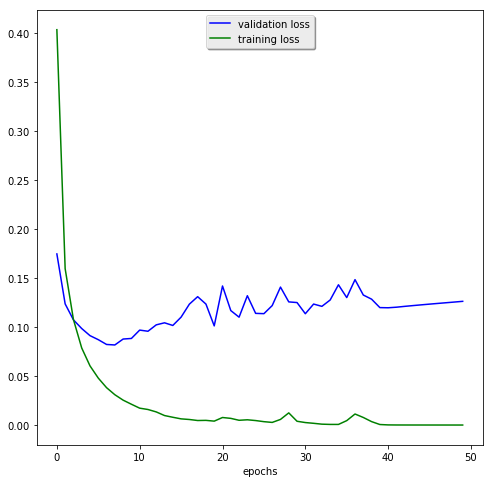

In [11]:
plt.figure(figsize=(8, 8))
plt.plot(val_losses, 'b', label="validation loss")
plt.plot(train_losses, 'g', label ="training loss")
plt.xlabel('epochs')
plt.legend(loc='upper center', shadow=True)
plt.show()

## Compute accuracy on the test set

The accuracy should be around >98%

In [12]:
test_predictions = s.run([predicted_classes], {input_X: X_test, input_y: y_test_vect})
miss_classified = np.count_nonzero(abs(y_test - test_predictions))
validation_accuracy = 100*(X_test.shape[0] - miss_classified) / X_test.shape[0]
print("Accuracy on training set : %f prct"%validation_accuracy)

Accuracy on training set : 98.110000 prct
